In the code cell below I import the python libraries that are used in this project. The dataset is loaded onto a pandas dataframe and df.head() is used to verify import path.

In [1]:
# Caffeine intake health prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/synthetic_coffee_health_10000.csv')

display(df.head())
display(df.info())
display(df.describe())

,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14  Smoking                

None

,ID,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000
mean,5000.50000,34.949100,2.509230,238.411010,6.636220,23.986860,70.617800,7.48704,0.20040,0.300700
std,2886.89568,11.160939,1.450248,137.748815,1.222055,3.906411,9.822951,4.31518,0.40032,0.458585
min,1.00000,18.000000,0.000000,0.000000,3.000000,15.000000,50.000000,0.00000,0.00000,0.000000
25%,2500.75000,26.000000,1.500000,138.750000,5.800000,21.300000,64.000000,3.70000,0.00000,0.000000
50%,5000.50000,34.000000,2.500000,235.400000,6.600000,24.000000,71.000000,7.50000,0.00000,0.000000
75%,7500.25000,43.000000,3.500000,332.025000,7.500000,26.600000,77.000000,11.20000,0.00000,1.000000
max,10000.00000,80.000000,8.200000,780.300000,10.000000,38.200000,109.000000,15.00000,1.00000,1.000000


The next step is to check if we have any missing values in our dataset by running isnull().sum(). By doing this we can see that the chosen dataset is clean of missing values except for health issues where 59.41% of people are free from health issues. One thing to note with this is that we cant be sure if all 5941 are healthy or if some of these are actual missing values. As the column Health_Issues is a categorical variable None, Mild, Moderate, Severe I am replacing the NaN's with string None to match the description of the dataset on Kaggle and to make it more consistent for modelling and analysis. I also dropped the column Coffee_Intake as it just contains how many cups of coffee individuals have but since we also have Caffeine_mg it is just redundant. Also it's not an accurate way to measure caffeine intake as I'm not sure if things like energy drinks are counted in it. Also check rows and number of columns

In [2]:
df_missing = pd.DataFrame(df)

df_missing = df_missing.drop(columns=['Coffee_Intake'])

display(df_missing.isnull().sum())

df_missing['Health_Issues'] = df_missing['Health_Issues'].fillna('None')
display(df_missing['Health_Issues'])

df_missing.shape

ID                            0
Age                           0
Gender                        0
Country                       0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64

0           None
1           None
2           Mild
3           Mild
4           Mild
          ...   
9995    Moderate
9996        Mild
9997        None
9998        None
9999        None
Name: Health_Issues, Length: 10000, dtype: object

(10000, 15)

The next step I took was to look at my data and how things are distributed and balanced. One thing I noticed right away was that the category for severe health problems only contain 17 individuals out of 10 000 (0.0017%) which is extremely rare so to make predictions with a model "better" I combined Moderate and Severe into a new column called ModerateAndSevere.

In [3]:
for col in ['Health_Issues', 'Gender', 'Stress_Level', 'Smoking', 'Alcohol_Consumption']:
    print(df_missing[col].value_counts())
    print()

df_colcombined = df_missing.copy()
df_colcombined['Health_Issues'] = df_colcombined['Health_Issues'].replace({'Moderate': 'ModerateAndSevere', 'Severe': 'ModerateAndSevere'})

df_colcombined['Health_Issues'].value_counts()


Health_Issues
None        5941
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64

Gender
Female    5001
Male      4773
Other      226
Name: count, dtype: int64

Stress_Level
Low       6989
Medium    2050
High       961
Name: count, dtype: int64

Smoking
0    7996
1    2004
Name: count, dtype: int64

Alcohol_Consumption
0    6993
1    3007
Name: count, dtype: int64



Health_Issues
None                 5941
Mild                 3579
ModerateAndSevere     480
Name: count, dtype: int64

After inspecting the general distribution of some of the attributes in my dataset I also chose to plot the data to take a closer look. First I selected all columns containing numerical data for histograms. As we can see in the histograms we have some strange patterns or phenomena in Age, Caffeine_mg, BMI and Heart_Rate. The biggest Age group by far is 18 which contains 935 entries while all other ages contain around 100-400 entries. The reason for this is unknown but one explanation could be that the creator/s of the dataset used 18 as the fallback age if it was unknown/nAn. It could also be that the dataset focused on young adults (18 year olds) and thus skewed the distribution of age. Since age is skewed interpretations regarding age should be proceeded with caution.

The same observation can be made for Caffeine_mg where the first bar in the histogram is the second biggest. But the explanation for this can be found in that 528 people drink no caffeine which seems logical. If the non-caffeine drinkers were to be removed from the histogram no weird distribution would be observed.

For BMI we also see this with 120 people being on BMI 15.0 which is considered severly underweight and super unhealthy. This does not seem to be a normal and natural distribution as it also must be some kind of fallback default value for when BMI is not known. Since the dataset is synthetically created from real-world patterns there might have been some error when generating BMI so values lower than 15 might be sat as 15, which is the minimum here.

The Heart Rate attribute has a little spike at 50 bpm with 214 people, which is a little strange as the rest follows a normal distribution. The reason for this could be as previously stated, that the default method for missing values is to impute the lowest value. It could also be that people with heart rates lower than 50, like athletes for example that can have resting heart rates around 40 get heart rate 50 here because it's the lowest value. It could also be that when the data was generated there was a limit at 50 so all values under it were put there.

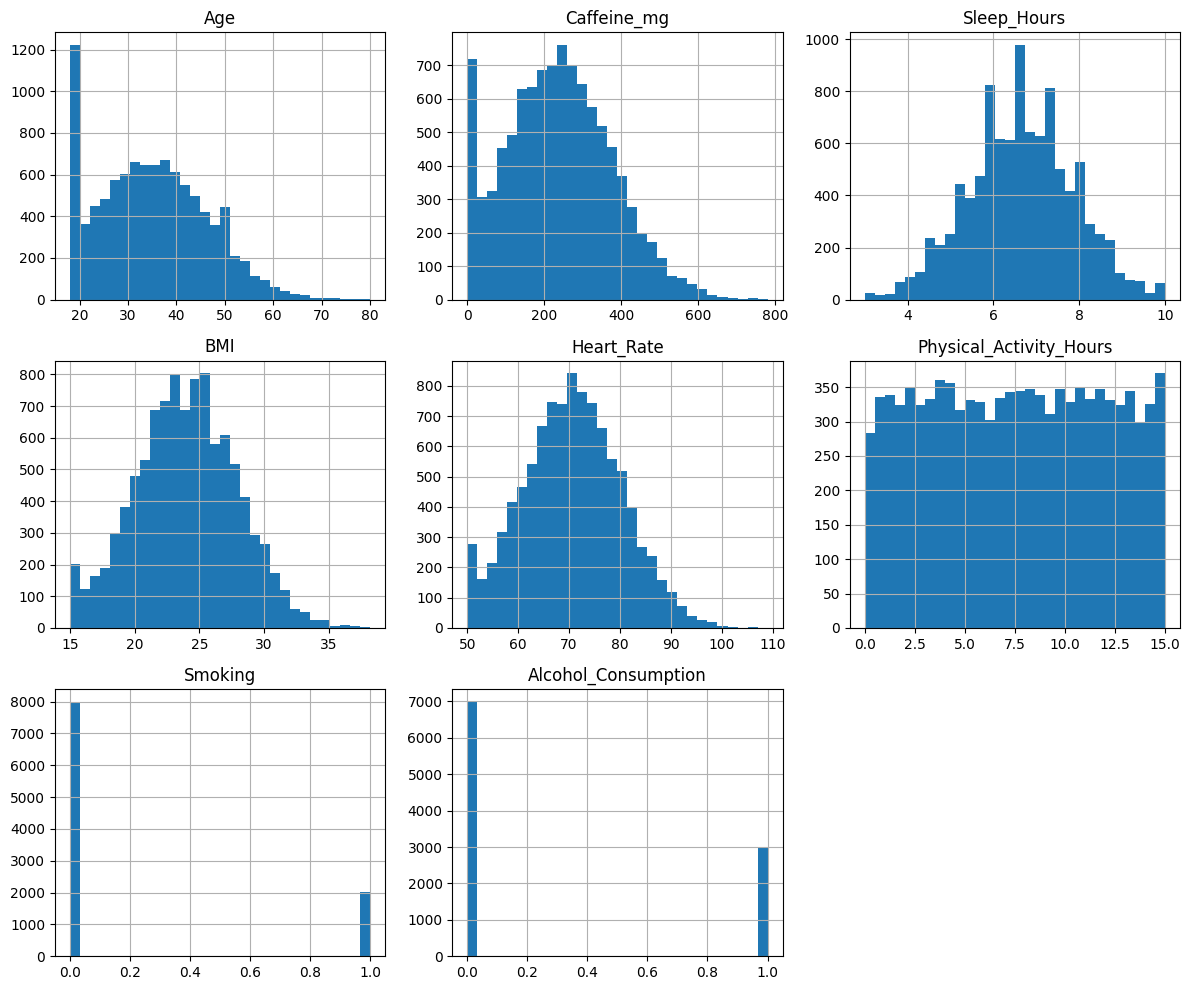

Age
18    935
19    133
20    154
21    171
22    194
23    221
24    229
25    256
26    225
27    291
Name: count, dtype: int64
528
BMI
15.0    120
15.1      9
15.2      6
15.3     11
15.4     16
15.5      8
15.6     20
15.7     13
15.8     11
15.9     14
Name: count, dtype: int64
Heart_Rate
50    214
51     62
52     87
53     74
54     96
55    118
56    161
57    156
58    188
59    227
Name: count, dtype: int64


In [41]:
int_cols = df_colcombined.select_dtypes(include=['int64', 'float64']).columns.drop('ID')
int_cols

df_int = df_colcombined[int_cols]
df_int.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

print(df_int['Age'].value_counts().sort_index().head(10))

print(df_int[df_int["Caffeine_mg"] == 0].shape[0])

print(df_int['BMI'].value_counts().sort_index().head(10))

print(df_int['Heart_Rate'].value_counts().sort_index().head(10))



Boxplots

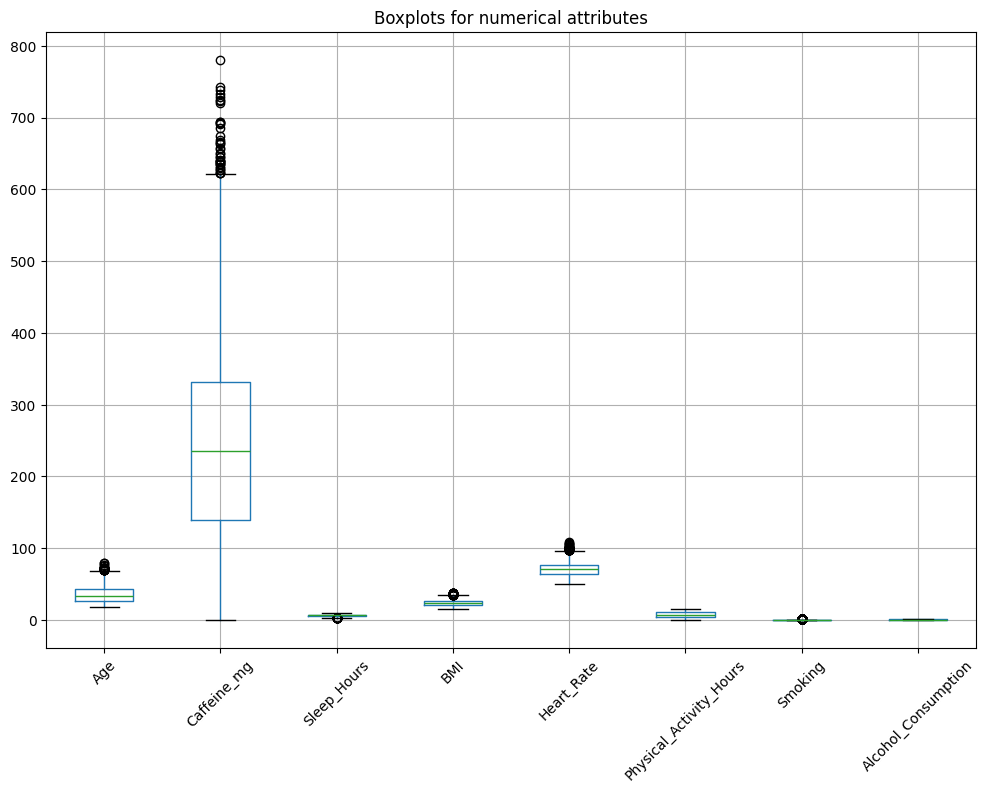

In [5]:
plt.figure(figsize=(12, 8))
df_int.boxplot(rot=45)
plt.title('Boxplots for numerical attributes')
plt.show()